### Basic Imports

In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
# Retina mode
%config InlineBackend.figure_format = 'retina'

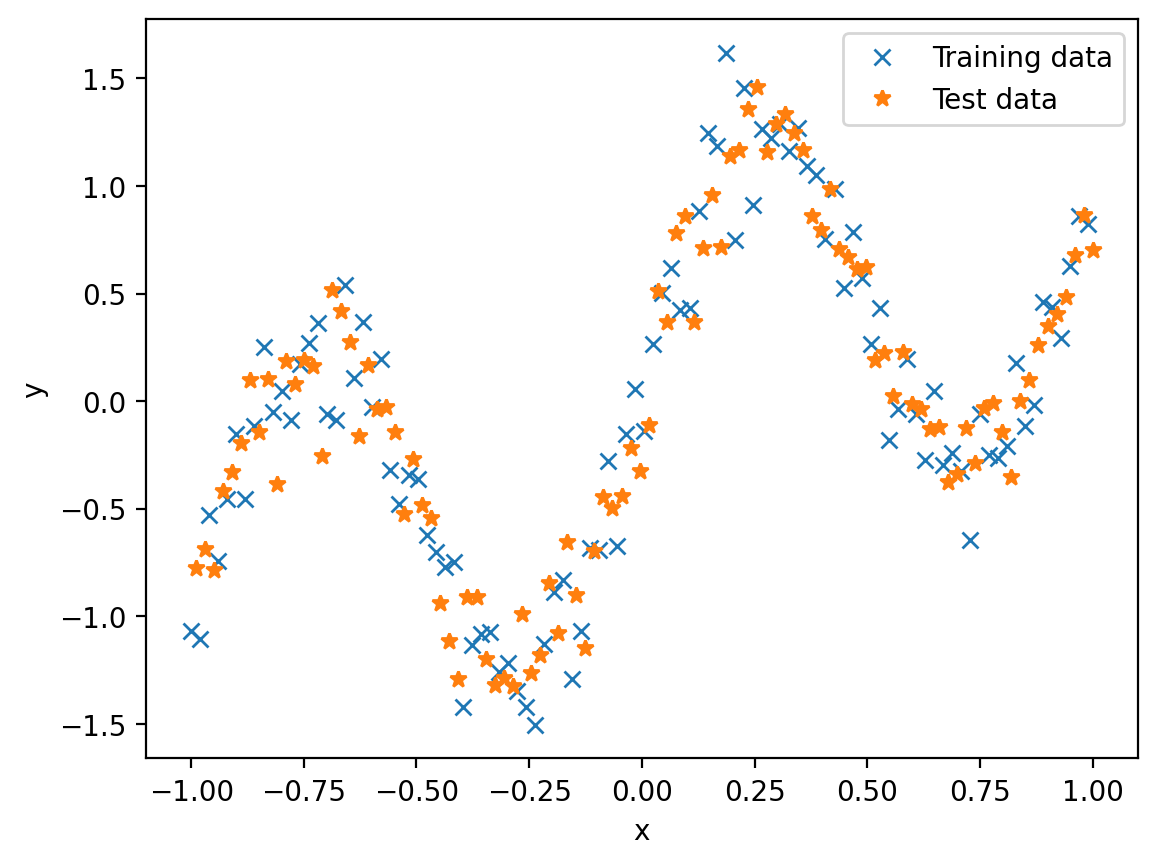

In [26]:
# Create training and test data
x_overall = torch.linspace(-1, 1, 200)

f_true = lambda x: torch.sin(2 * np.pi * x) + x

noise = torch.distributions.Normal(0, 0.2)

y_overall = f_true(x_overall) + noise.sample(x_overall.shape)

x_train = x_overall[::2]
y_train = y_overall[::2]

x_test = x_overall[1::2]
y_test = y_overall[1::2]

def plot_train_test():
    plt.plot(x_train, y_train, 'x', label='Training data')
    plt.plot(x_test, y_test, '*', label='Test data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plot_train_test()

In [27]:
def mean_function(x):
    return 0.0*x

def covariance_function(x1, x2):
    return torch.exp(-0.5 * (x1 - x2).pow(2))

In [28]:
mean_vector = mean_function(x_overall)
covariance_matrix = covariance_function(x_overall.unsqueeze(1), x_overall.unsqueeze(0))

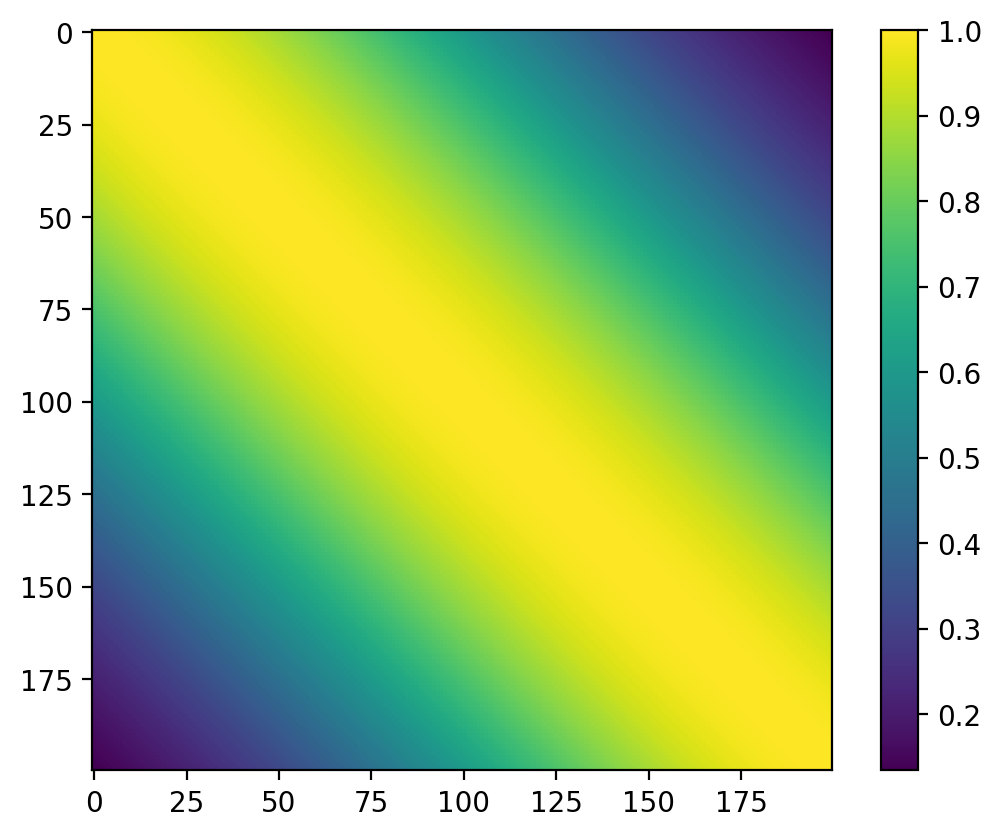

In [29]:
plt.imshow(covariance_matrix.detach().numpy())
plt.colorbar()

In [30]:
mvn = torch.distributions.MultivariateNormal(mean_vector, covariance_matrix + 1e-4 * torch.eye(len(x_overall)))
y_sample_overall = mvn.sample([500])

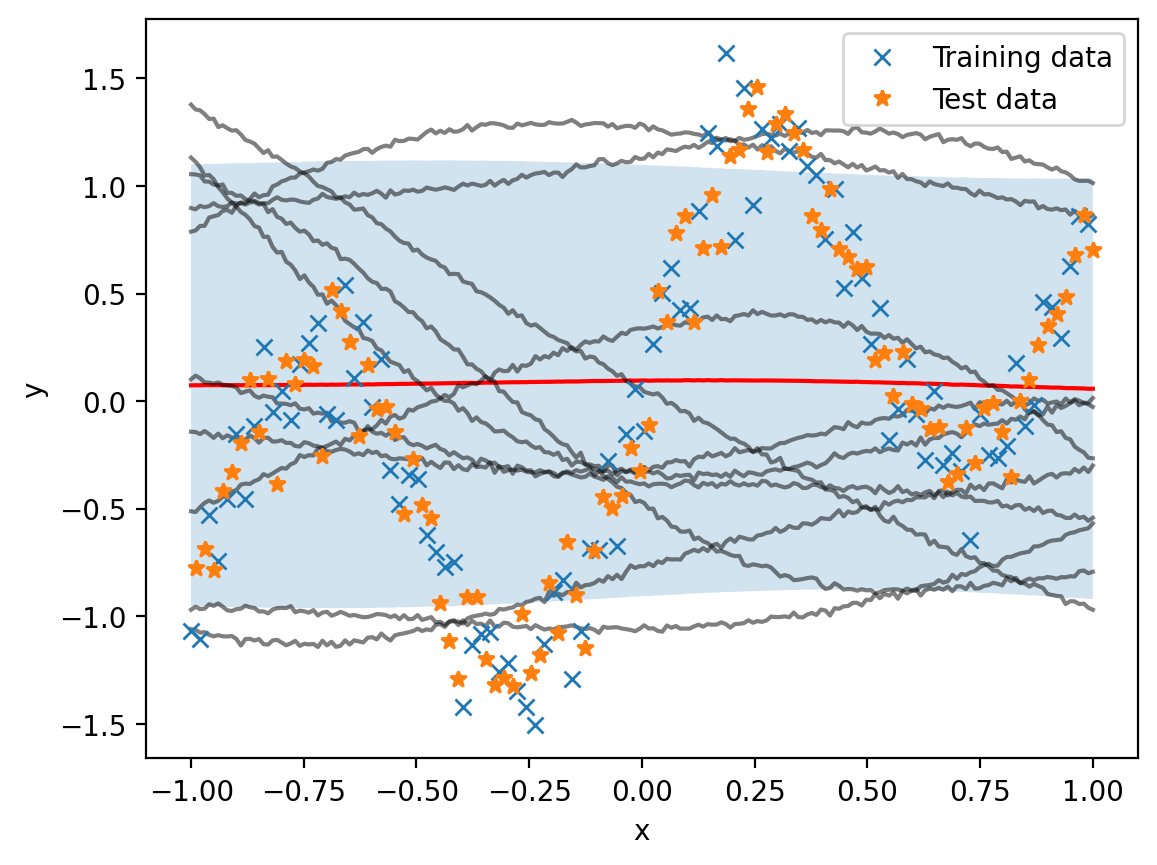

In [31]:
plt.plot(x_overall, y_sample_overall.mean(dim=0), color='r')
plt.fill_between(x_overall, y_sample_overall.mean(dim=0) - y_sample_overall.std(dim=0), 
                 y_sample_overall.mean(dim=0) + y_sample_overall.std(dim=0), alpha=0.2)

# Draw some samples
for i in range(10):
    plt.plot(x_overall, y_sample_overall[i], color='k', alpha=0.5)
    
plot_train_test()

In [32]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.fc1(x)
        x = torch.sin(x)
        x = self.fc2(x)
        x = torch.sin(x)
        x = self.fc3(x)
        x = torch.sin(x)
        x = self.fc4(x)
        return x

In [33]:
mean_function = SimpleMLP(1, 10, 1)
cov_function = SimpleMLP(1, 10, 1)

torch.Size([200])
torch.Size([200, 200])


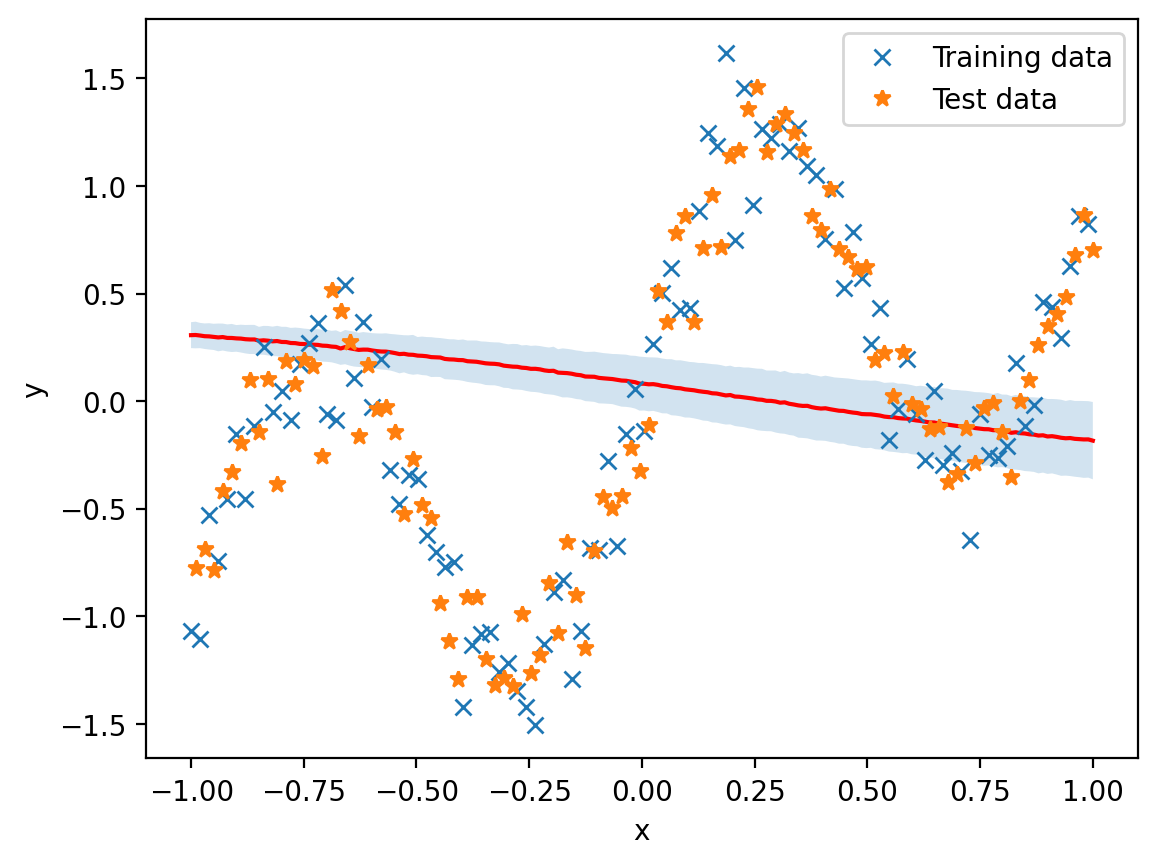

In [34]:
def plot_model(mean_function, cov_function, n_samples=0):
    mu = mean_function(x_overall).squeeze()
    print(mu.shape)
    L = cov_function(x_overall)
    L_transpose = torch.transpose(L, 0, 1)
    cov_nn = torch.mm(L, L_transpose)
    print(cov_nn.shape)
    
    mvn = torch.distributions.MultivariateNormal(mu, cov_nn + 1e-3 * torch.eye(len(mu)))
    y_sample_overall = mvn.sample([500])
    
    plt.plot(x_overall, y_sample_overall.mean(dim=0), color='r')
    plt.fill_between(x_overall, y_sample_overall.mean(dim=0) - y_sample_overall.std(dim=0), 
                    y_sample_overall.mean(dim=0) + y_sample_overall.std(dim=0), alpha=0.2)

    if n_samples > 0:
        # Draw some samples
        for i in range(n_samples):
            plt.plot(x_overall, y_sample_overall[i], color='k', alpha=0.5)
        
#plot_train_test()
    
plot_model(mean_function, cov_function)
plot_train_test()

torch.Size([200])
torch.Size([200, 200])


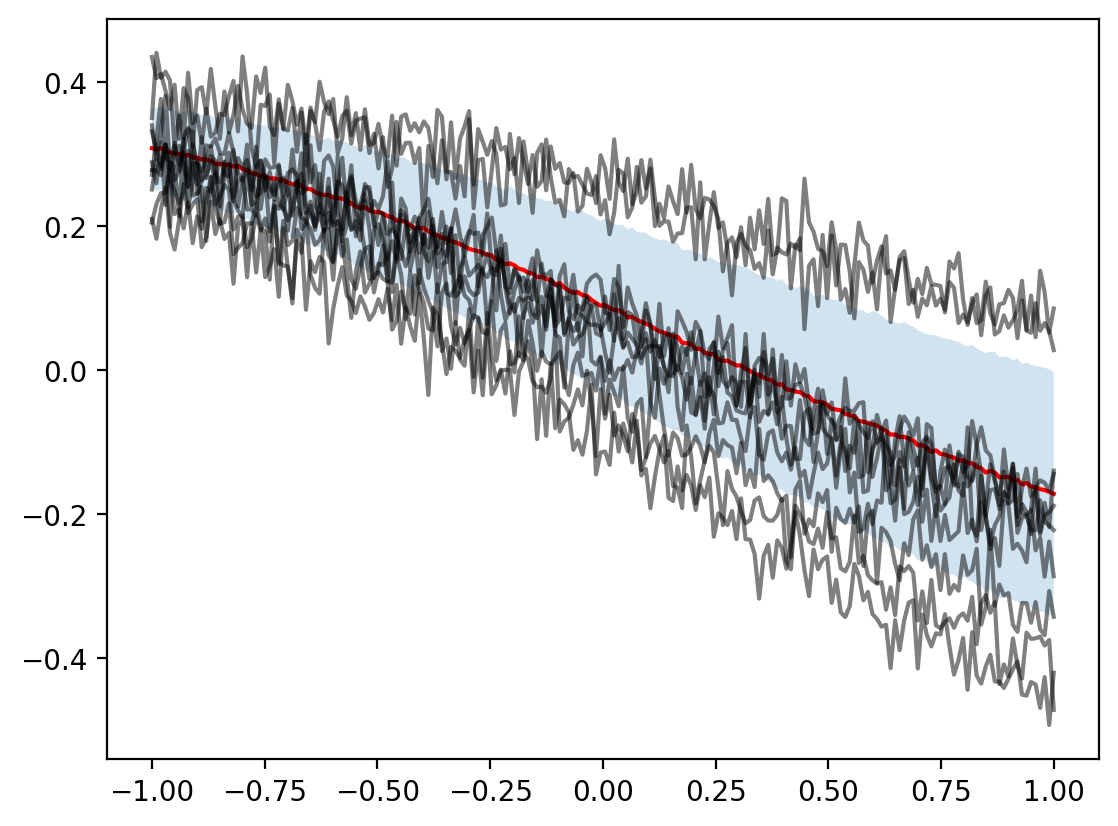

In [36]:
plot_model(mean_function, cov_function, n_samples=10)

In [37]:
# Train the models for mean and covariance

mean_function = SimpleMLP(1, 12, 1)
cov_function = SimpleMLP(1, 12, 1)

params = list(mean_function.parameters()) + list(cov_function.parameters())

optimizer = torch.optim.Adam(params, lr=1e-2)

n_epochs = 6000

for i in range(n_epochs):
    mu = mean_function(x_train.squeeze()).squeeze()
    L = cov_function(x_train.squeeze())
    L_transpose = torch.transpose(L, 0, 1)
    cov_nn = torch.mm(L, L_transpose)

    mvn = torch.distributions.MultivariateNormal(mu, cov_nn + 1e-3 * torch.eye(len(x_train)))
    
    loss = -mvn.log_prob(y_train).mean()
    if i%200 == 0:
        print(i, loss.item())
    
    
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    


0 28912.224609375
200 1482.7979736328125
400 1479.265869140625
600 1478.366943359375
800 1477.191650390625
1000 1476.39599609375
1200 1474.93359375
1400 1473.19384765625
1600 1478.0535888671875
1800 1463.9178466796875
2000 1464.5849609375
2200 1452.972412109375
2400 1452.342041015625
2600 1451.6229248046875
2800 1451.265869140625
3000 1451.5020751953125
3200 1448.234130859375
3400 1450.8121337890625
3600 1443.739990234375
3800 1442.154052734375
4000 1440.373291015625
4200 1439.240234375
4400 1438.522705078125
4600 1437.9898681640625
4800 1435.490234375
5000 1433.228759765625
5200 1422.52001953125
5400 1371.302001953125
5600 1366.93408203125
5800 1362.10693359375


torch.Size([200])
torch.Size([200, 200])


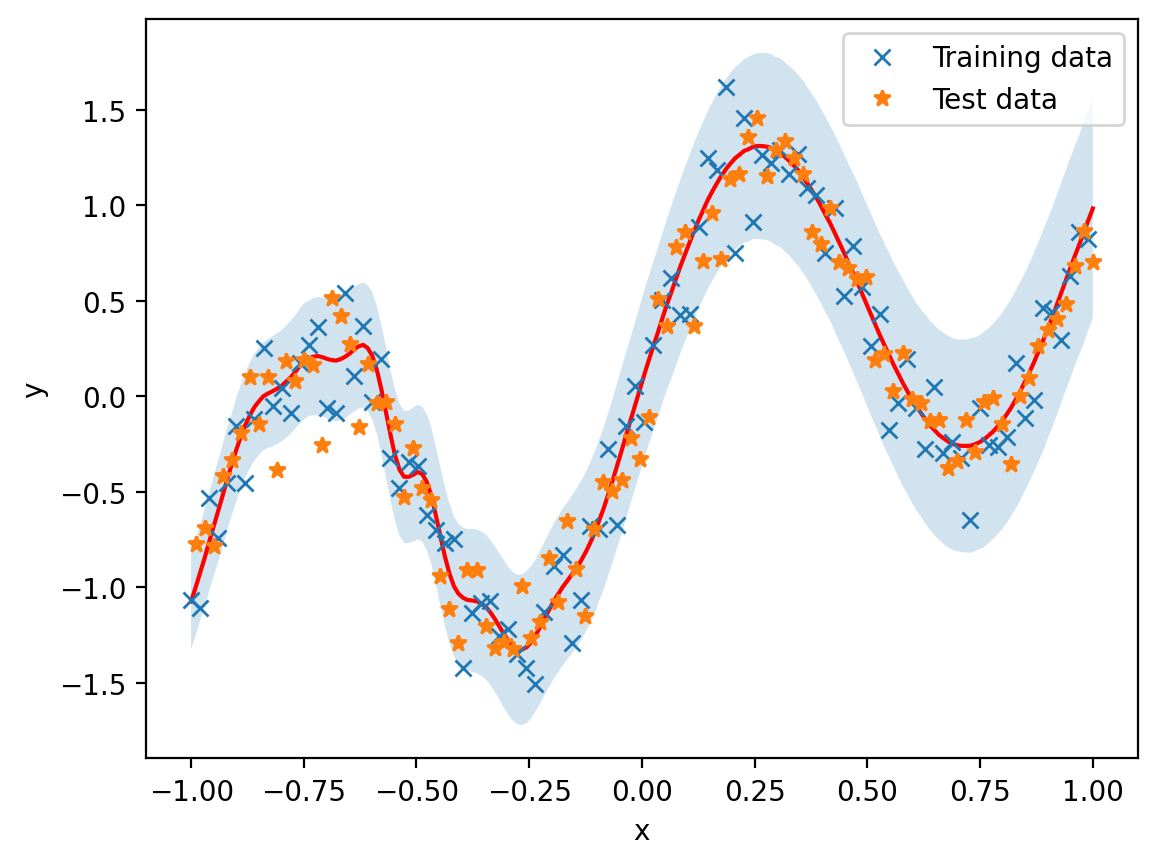

In [38]:
plot_model(mean_function, cov_function)
plot_train_test()